In a [previous post](/posts/gaussian_dispersion_example/) I modeled an example of a plume from an elevated stack. In that example I assumed very stable conditions and a low windspeed -- pasquill stability class F and a windspeed of 1.5m/s -- as the worst case. This was an error!

For neutrally buoyant releases at or near ground-level that is a common "worst case", for example when considering the potential impact due to a vapour cloud explosion. But for elevated stacks, releasing a buoyant plume, a class D stability with a moderate windspeed is often recommended. I thought it would be interesting to explore how the maximum concentration at the point of interest -- an elevated work area downwind of the stack -- varies with stability class and windspeed.

I am not going to repeat all of the assumptions and working out of the previous notebook, the important results are in the source code for this post. I have also re-defined some of the functions to be a little more re-useable and to represent other stability cases not covered in the original notebook.

In [1]:
#| echo: false
#| output: false

using Unitful
using ForwardDiff
using Roots
using Plots

# Parameters of the problem

hₛ = 10u"m"   # stack height
Dₛ = 2u"m"    # stack diameter
Tₛ = 450u"K"  # stack exit temperature

h₁ = hₛ      # height of platform, m
x₁ = 100u"m" # distance to platform, m

pₐ = 101.325u"kPa" # ambient pressure, 1atm
Tₐ = 298.15u"K"    # ambient temperature, 25°C

Q = 0.002950437713234783u"kg/s"
Vₛᵒ = 30.385903267077627u"m^3/s"
vₛ = 14.847213558996382u"m/s"
uₛ = 1.5u"m/s"

TWA = uconvert(u"kg/m^3", 40u"mg/m^3")

g = 9.80616u"m/s^2" # acceleration due to gravity
s(T, Γ=0.035u"K/m") = (g/T) * Γ

Fb = g * vₛ * Dₛ^2 * (Tₛ - Tₐ) / (4Tₛ)

49.1299376393856 m^4 s^-3

In [2]:
#| echo: false
#| output: false

# Buoyancy check

function ΔTc(Fb, Ts, vs, d; s=0.0, stable::Bool=false)
    if stable == true
        return 0.019582 * Ts * vs * √(s)
    elseif Fb < 55
        return 0.0297 * Ts * (vs/d^2)^(1/3)
    else
        return 0.00575 * Ts * (vs^2/d)^(1/3)
    end
end

function ΔTc(Fb::Quantity, Ts::Quantity, vs::Quantity, d::Quantity; s::Quantity=0.0u"s^-2", stable::Bool=false)::Quantity
    Fb = ustrip(u"m^4/s^3", Fb)
    Ts = ustrip(u"K", Ts)
    vs = ustrip(u"m/s", vs)
    d = ustrip(u"m", d)
    s = ustrip(u"s^-2", s)
    ΔT = ΔTc(Fb, Ts, vs, d, s=s, stable=stable)
    return ΔT*1u"K"
end

(Tₛ - Tₐ) > ΔTc(Fb, Tₛ, vₛ, Dₛ)

true

In [3]:
#| echo: false
#| output: false

# Plume rise for stable and unstable conditions

function Δhᵣ(x, u; Fb, s=0.0, stable::Bool=false)
    if stable
        xf = 2.0715*u/√(s)
        Δhr = 2.6*(Fb/(u*s))^(1/3)
    elseif Fb < 55
        xf = 49*Fb^(5/8)
        Δhr = 21.425*Fb^(0.75)/u
    else
        xf = 119*Fb^(2/5)
        Δhr = 38.71*Fb^(0.6)/u
    end
    
    if x < xf
        Δhi = 1.60*(Fb*x^2/u^3)^(1/3)
        Δhr = min(Δhi, Δhr)
    end
    
    return Δhr
end

function Δhᵣ(x::Quantity, u::Quantity; Fb::Quantity, s::Quantity=0.0u"s^-2", stable::Bool=false)::Quantity
    x = ustrip(u"m", x)
    Fb = ustrip(u"m^4/s^3", Fb)
    u = ustrip(u"m/s", u)
    s = ustrip(u"s^-2", s)
    Δhr = Δhᵣ(x, u, Fb=Fb, s=s, stable=stable)
    return Δhr*1u"m"
end

Δhᵣ (generic function with 2 methods)

In [4]:
#| echo: false
#| output: false

# Dispersion Functions

σy_funs = Dict{String,Function}(
      "A" => x -> 0.493*x^0.88,
      "B" => x -> 0.337*x^0.88,
      "C" => x -> 0.195*x^0.90,
      "D" => x -> 0.128*x^0.90,
      "E" => x -> 0.091*x^0.91,
      "F" => x -> 0.067*x^0.90)

function σy(x; pasquill::String)
    return σy_funs[pasquill](x)
end

function σy(x::Quantity; pasquill::String)::Quantity
    x = ustrip(u"m", x)
    return σy(x, pasquill=pasquill)*1u"m"
end

function σy(pasquill::String)::Function
    return x -> σy(x, pasquill=pasquill)
end

struct ZDisp
    f1::Function
    f2::Function
    lim::Float64
end

σz_funs = Dict{String, ZDisp}(
      "A" => ZDisp(
                x -> 0.087*x^1.10,
                x -> 10^(-1.67 + 0.902*log10(x) + 0.181*log10(x)^2),
                300.0),
      "B" => ZDisp(
              # Note: Lee's gives the commented out form but it is wrong
              # x -> 0.0135*x^0.95

                x -> 0.135*x^0.95,
                x -> 10^(-1.25 + 1.09*log10(x) + 0.0018*log10(x)^2),
                500.0),
      "C" => ZDisp(
                x -> 0.0,
                x -> 0.112*x^0.91,
                0.0),
      "D" => ZDisp(
                x -> 0.093*x^0.85,
                x -> 10^(-1.22 + 1.08*log10(x) - 0.061*log10(x)^2),
                500.0),
      "E" => ZDisp(
                x -> 0.082*x^0.82,
                x -> 10^(-1.19 + 1.04*log10(x) - 0.070*log10(x)^2),
                500.0),
      "F" => ZDisp(
                x -> 0.057*x^0.80,
              # Note: Lee's gives the commented out form but it is wrong
              # x -> 10^(1.91 - 1.37*log10(x) - 0.119*log10(x)^2)
                x -> 10^(-1.91 + 1.37*log10(x) - 0.119*log10(x)^2),
                500.0))

function σz(x; pasquill::String)
    zdisp = σz_funs[pasquill]
    if x < zdisp.lim
        return zdisp.f1(x)
    else
        return zdisp.f2(x)
    end
end

function σz(x::Quantity; pasquill::String)::Quantity
    x = ustrip(u"m", x)
    return σz(x, pasquill=pasquill)*1u"m"
end

function σz(pasquill::String)::Function
    return x -> σz(x, pasquill=pasquill)
end

σz (generic function with 3 methods)

In [5]:
#| echo: false
#| output: false

# Gaussian plume dispersion equation

function C(x, y, z; Q, u, h, Δh::Function, σy::Function, σz::Function)
    Δhr = Δh(x, u)
    hₑ  = h + Δhr
    σyₑ = √( (Δhr/3.5)^2 + σy(x)^2 )
    σzₑ = √( (Δhr/3.5)^2 + σz(x)^2 )

    return (Q/(2*π*u*σyₑ*σzₑ)) * exp(-0.5*(y/σyₑ)^2) * ( exp(-0.5*((z-hₑ)/σzₑ)^2) + exp(-0.5*((z+hₑ)/σzₑ)^2) )
end

function C(u; x, y, z, Q, h, Δh::Function, σy::Function, σz::Function)   
    return C(x, y, z, Q=Q, u=u, h=h, Δh=Δh, σy=σy, σz=σz)
end

C (generic function with 2 methods)

## Pasquill Stability

As a refresher, Pasquill stability classes are a qualitative way of describing the atmospheric stability -- the tendency of the atmosphere to resist or enhance vertical motion. Stability is itself related to the temperature gradient with height, wind speed, and various other things. For a simple model such as this the key model parameters are tabulated with respect to the Pasquill stability, which is why it is relevant to this discussion.

### Pasquill Stability Classes

| Stability Class | Description                |
|-----------------|----------------------------|
| A               | Extremely unstable         |
| B               | Unstable                   |
| C               | Slightly unstable          |
| D               | Neutral                    |
| E               | Slightly stable            |
| F               | Stable to extremely stable |

In general the more stable the class the less dispersion, and thus the higher the concentration within the plume. Which is why class F is typically used for a ground level, neutrally buoyant, cloud. However plume rise is also a function of stability and, in general, more stable plumes rise without as much dispersion and thus the *ground level* concentration is lower than if the plume dispersed more. Furthermore the plume rise is a function of windspeed, the greater the windspeed the less the plume rises before leveling off and, again, the greater the ground level concentration.

We can visualize the relationship between windspeed, stability class, and the concentration at the point of interest with the following plot which includes plume rise relationships for unstable, neutral, and stable atmospheres.

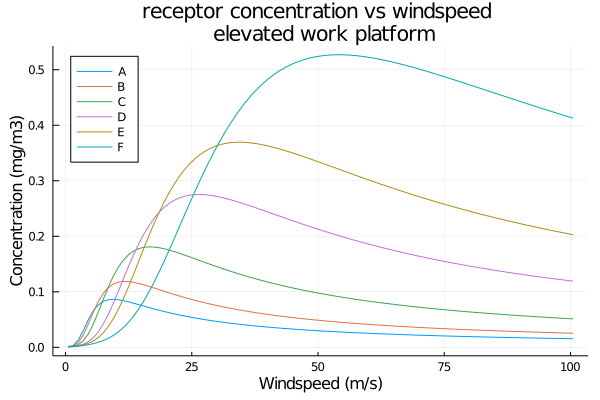

In [6]:
#| echo: false

oel = ustrip(u"mg/m^3", TWA)

function stable_rise(pasquill::String)::Function
    if pasquill == "E"
        Γ = 0.020u"K/m"
    elseif pasquill == "F"
        Γ = 0.035u"K/m"
    else
        error("Invalid Pasquill Stability Class, stable rise is for either E or F")
    end
    
    s_val = ustrip(s(Tₐ, Γ))
    Fb_val = ustrip(Fb)
    
    return (x,u) -> Δhᵣ(x, u; Fb=Fb_val, s=s_val, stable=true)
    
end

function unstable_rise(pasquill::String)::Function
    if pasquill in ["A" "B" "C" "D"]
        Fb_val = ustrip(Fb)
        return (x,u) -> Δhᵣ(x, u; Fb=Fb_val, stable=false)
    else
        error("Invalid Pasquill Stability Class, unstable/neutral rise is for A, B, C, or D")
    end
end

Q_u = ustrip(Q)
u_u = ustrip(uₛ)
h_u = ustrip(hₛ)

us = 0.5:1:101

As = C.(us, x=ustrip(x₁), y=0.0, z=ustrip(h₁), Q=Q_u, h=h_u, Δh=unstable_rise("A"), σy=σy("A"), σz=σz("A"))*1e6
Bs = C.(us, x=ustrip(x₁), y=0.0, z=ustrip(h₁), Q=Q_u, h=h_u, Δh=unstable_rise("B"), σy=σy("B"), σz=σz("B"))*1e6
Cs = C.(us, x=ustrip(x₁), y=0.0, z=ustrip(h₁), Q=Q_u, h=h_u, Δh=unstable_rise("C"), σy=σy("C"), σz=σz("C"))*1e6
Ds = C.(us, x=ustrip(x₁), y=0.0, z=ustrip(h₁), Q=Q_u, h=h_u, Δh=unstable_rise("D"), σy=σy("D"), σz=σz("D"))*1e6
Es = C.(us, x=ustrip(x₁), y=0.0, z=ustrip(h₁), Q=Q_u, h=h_u, Δh=stable_rise("E"), σy=σy("E"), σz=σz("E"))*1e6
Fs = C.(us, x=ustrip(x₁), y=0.0, z=ustrip(h₁), Q=Q_u, h=h_u, Δh=stable_rise("F"), σy=σy("F"), σz=σz("F"))*1e6

plot(us, [As Bs Cs Ds Es Fs], lab=["A" "B" "C" "D" "E" "F"])
plot!(title="receptor concentration vs windspeed \n elevated work platform", 
      ylabel= "Concentration (mg/m3)", 
      xlabel="Windspeed (m/s)",
      leg=:topleft)

We note that, as we expect, lower stability (e.g. A or B) corresponds to a higher groundlevel concentration at low windspeed, but at high windspeed higher stability leads to a greater groundlevel concentration.

At first blush it would appear that class F is still the worst case, however this plot naively assumes atmospheric stability is unrelated to windspeed. This is not true and roughly speaking the stability transitions towards classes C and D as the windspeed increases.

### Pasquill Stability and Windspeed

#### Pasquill Stability vs Incoming Solar Radiation

| Windspeed (m/s) | Strong | Moderate | Slight |
|:---------------:|:------:|:--------:|:------:|
| < 2             | A      |  A - B   | B      |
| 2 - 3           | A - B  | B        | C      |
| 3 - 5           | B      | B - C    | C      |
| 5 - 6           | C      | C - D    | D      |
| > 6             | C      | D        | D      |


#### Pasquill Stability vs Nighttime Cloud Cover

| Windspeed (m/s) | > 4/8 cloud | < 3/8 cloud |
|:---------------:|:-----------:|:-----------:|
| < 2             |             |             |
| 2 - 3           | E           | F           |
| 3 - 5           | D           | E           |
| 5 - 6           | D           | D           |
| > 6             | D           | D           |

To represent this crudely, the plots can be chopped off at the windspeed limits from the tables above. So, for example, the class F plot would end at 3m/s.

The plots also present an obvious way of finding the worst case for a particular scenario: find the extremal point for the worst stability class. This is found rather simply by setting the derivative to zero. Something that would be complicated to do analytically but is quite straight forward when using the `ForwardDiff` library for automatic differentiation.

In [7]:
# ForwardDiff doesn't play nicely with unitful
# so values have to be stripped of units first

Fb′ = ustrip(Fb)
x₁′ = ustrip(x₁)
h₁′ = ustrip(h₁)
Q′  = ustrip(Q)
hₛ′ = ustrip(hₛ)

∂Cᵤ(u) = ForwardDiff.derivative(u -> C(u, x=x₁′, 
                                          y=0.0, 
                                          z=h₁′, 
                                          Q=Q′, 
                                          h=hₛ′, 
                                          Δh=(x,u) -> Δhᵣ(x, u, Fb=Fb′, stable=false), 
                                          σy=σy("D"), 
                                          σz=σz("D")), float(u))

∂Cᵤ (generic function with 1 method)

In [8]:
# Find the point where ∂C/∂u = 0
# Initial guess of 25 just by eye-ball

u_worst = find_zero(∂Cᵤ, 25)

C_worst = C(x₁, 0.0u"m", h₁, 
            u=u_worst*1u"m/s", 
            Q=Q, 
            h=hₛ, 
            Δh=(x,u) -> Δhᵣ(x, u, Fb=Fb, stable=false), 
            σy=σy("D"), 
            σz=σz("D"))

uconvert(u"mg/m^3", C_worst)

0.2753490886768969 mg m^-3

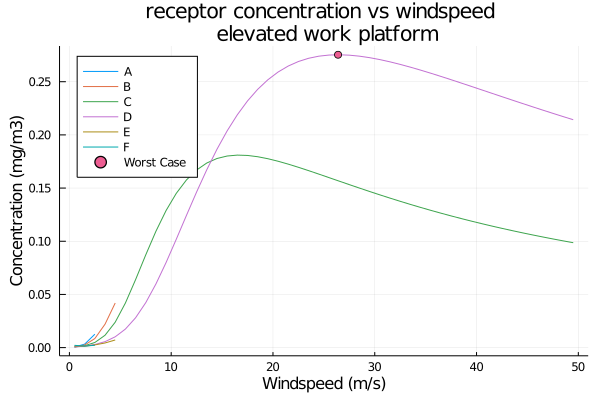

In [9]:
#| echo: false

plot(us[ us .<= 3], As[us .<= 3], lab="A")
plot!(us[ us .<= 5], Bs[us .<= 5], lab="B")
plot!(us[ us .< 50], Cs[ us .< 50], lab="C")
plot!(us[ us .< 50], Ds[ us .< 50], lab="D")
plot!(us[ us .<= 5], Es[us .<= 5], lab="E")
plot!(us[ us .<= 3], Fs[us .<= 3], lab="F")
plot!([u_worst], [ustrip(u"mg/m^3",C_worst)], seriestype = :scatter, lab="Worst Case")
plot!(title="receptor concentration vs windspeed \n elevated work platform", 
      ylabel= "Concentration (mg/m3)", 
      xlabel="Windspeed (m/s)",
      leg=:topleft)

We find that the worst case is indeed class D but with quite a high windspeed, ~26.4m/s or 95kph, which would be considered a 10 on the [Beaufort scale](https://www.canada.ca/en/environment-climate-change/services/general-marine-weather-information/understanding-forecasts/beaufort-wind-scale-table.html) with trees being uprooted and considerable structural damage. It's unlikely that workers would still be on the platform and it may not even be the case that the scaffolding would still be standing!

Regardless we can look at the contour plots at the work platform elevation and vertically, along the centerline.

*Note* the colours are scaled to 4mg/m^3, one tenth the occupational limit of 40mg/m^3.

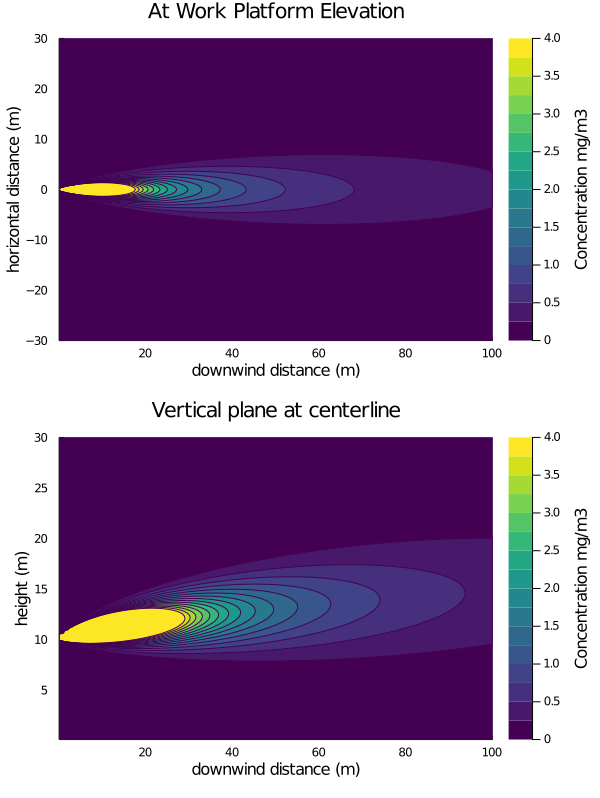

In [10]:
#| echo: false

xs = 0.1:1:101
ys = -30:.3:30
zs = 0.1:.1:30

l = @layout [a; b]

p1 = contour(xs, ys, (x,y) -> C(x, y, ustrip(h₁), u=u_worst, Q=Q_u, h=h_u, Δh=unstable_rise("D"), σy=σy("D"), σz=σz("D"))*1e6,
        c= :viridis, fill = true, clim=(0, 4), colorbar_title="Concentration mg/m3",
        title="At Work Platform Elevation", ylabel= "horizontal distance (m)", xlabel="downwind distance (m)")
p2 = contour(xs, zs, (x,z) -> C(x, 0.0, z, u=u_worst, Q=Q_u, h=h_u, Δh=unstable_rise("D"), σy=σy("D"), σz=σz("D"))*1e6,
        c= :viridis, fill = true, clim=(0, 4), colorbar_title="Concentration mg/m3",
        title="Vertical plane at centerline", ylabel= "height (m)", xlabel="downwind distance (m)")
plot(p1, p2, layout = l, size=(600,1.33*600))

Another interesting impact of elevated releases like this is that the worst concentration for an observer on the ground is often a significant distance *downwind* of the stack. Because the plume must disperse downwards.

Below is a contour plot showing the downwind concentration at a 2m elevation -- the height of a reasonably tall person. Note the scale is set to even lower concentrations. The maximum of the colour bar is 1000x lower than the occupational limit.

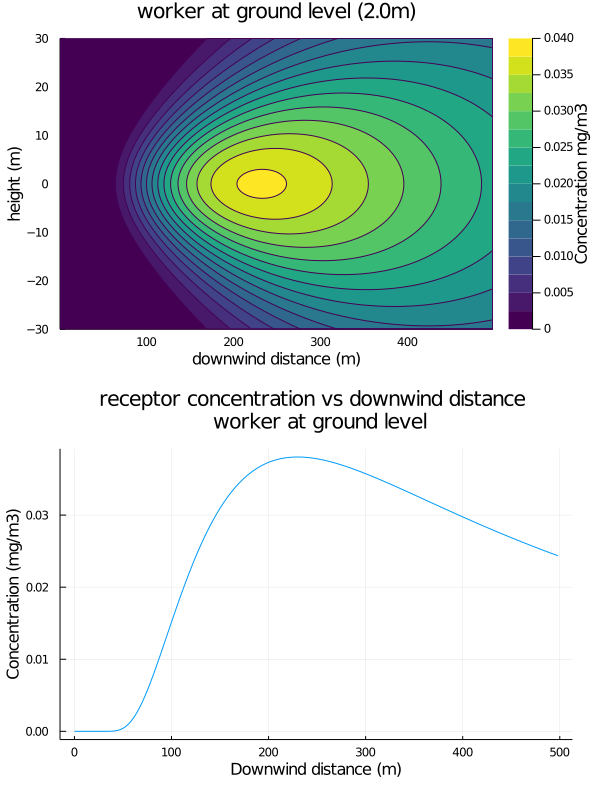

In [11]:
#| echo: false

gxs = 0.1:2:500

gl = @layout [a; b]

p3 = contour(gxs, ys, (x,y) -> C(x, y, 2.0, u=u_worst, Q=Q_u, h=h_u, Δh=unstable_rise("D"), σy=σy("D"), σz=σz("D"))*1e6,
        c= :viridis, fill = true, clim=(0, .04), colorbar_title="Concentration mg/m3",
        title="worker at ground level (2.0m)", 
        ylabel= "height (m)", 
        xlabel="downwind distance (m)")

p4 = plot(gxs, x->C(x, 0.0, 2.0, u=u_worst, Q=Q_u, h=h_u, Δh=unstable_rise("D"), σy=σy("D"), σz=σz("D"))*1e6,
          lab=false,
          title="receptor concentration vs downwind distance \n worker at ground level", 
          ylabel= "Concentration (mg/m3)", 
          xlabel="Downwind distance (m)",
          leg=:topleft)

plot(p3, p4, layout = gl, size=(600,1.33*600))

## Multiple Concentrations

Previously, in [the discussion of the occupational exposure limit](https://aefarrell.github.io/2020/12/05/gaussian_dispersion_example/#the-concentration-of-interest) I noted that, in general, one would have to account for the impact of multiple substances in the flue gas, though in that particular example I was only modeling carbon monoxide and I just moved on. I think I left the impression that one would have to model each substance separately and, at least with this simple gaussian dispersion model, that is very much not the case.

Consider for some substance *i* being released with in-stack concentration $C_{s,i}$, we can define a dimensionless "dilution" $\chi$ as

$$ \chi \left( x, y, z \right) = { C_i \left( x, y, z \right) \over C_{s,i} } $$

Assuming the in-stack concentration to be simply the mass emission rate of *i* divided by the volumetric flow-rate[^1]

[^1]:At standard state, because the concentrations given for the occupational exposure limits are given in terms of a volume at standard state. This is also a potential error in the original model as it does not correct the concentrations back to standard state, nor does it really track temperature to make that even possible, especially near the stack.

$$ C_{s,i} = { Q_i \over V_s^o } $$

and recalling the concentration function from the gaussian dispersion model

$$ C_i \left( x, y, z \right) = {Q_i \over 2 \pi u \sigma_{ye} \sigma_{ze} } f \left( x, y, z \right) $$

where $ f \left( x, y, z \right) $ is the products of the exponentials, and is a function of x, y, z only. Putting all that together we get an expression for the dilution that does not depend upon the substance being released

$$ \chi \left( x, y, z \right) = {V_s^o \over 2 \pi u \sigma_{ye} \sigma_{ze} } f \left( x, y, z \right) $$

If you have already done the modeling for a particular substance then calculate $\chi$ for the points of interest by dividing the concentrations by the in stack concentration, otherwise substitute the formula for $\chi$ given above for the concentration and model that instead.

Then, when evaluating multiple substances, the test[^2]

[^2]: From [CCOHS](https://www.ccohs.ca/oshanswers/hsprograms/occ_hygiene/occ_exposure_limits.html)

$$ \sum_i {C_i \left( x, y, z \right) \over T_i } \lt 1 $$

becomes

$$ \chi \left( x, y, z \right) \cdot \sum_i {C_{s,i} \over T_i } \lt 1 $$

where $T_i$ is the relevant occupational exposure limit.

To recap, instead of calculating the concentrations at the points of interest using a gaussian dispersion model multiple times, calculate a dimensionless *dilution* at the points of interest and apply that to the in stack concentrations of all of the substances of interest. Then combine those as per the relevant rules for occupational hygiene.

Below are a series of contour plots showing the dilution $\chi$, where colours are are from 0-5% -- i.e. the concentration within the yellow region is &ge; 5% the in-stack concentration.

*Note:* This is backwards to the usual way of defining dilution, where a $\chi$ of 5% would be a 95% dilution.

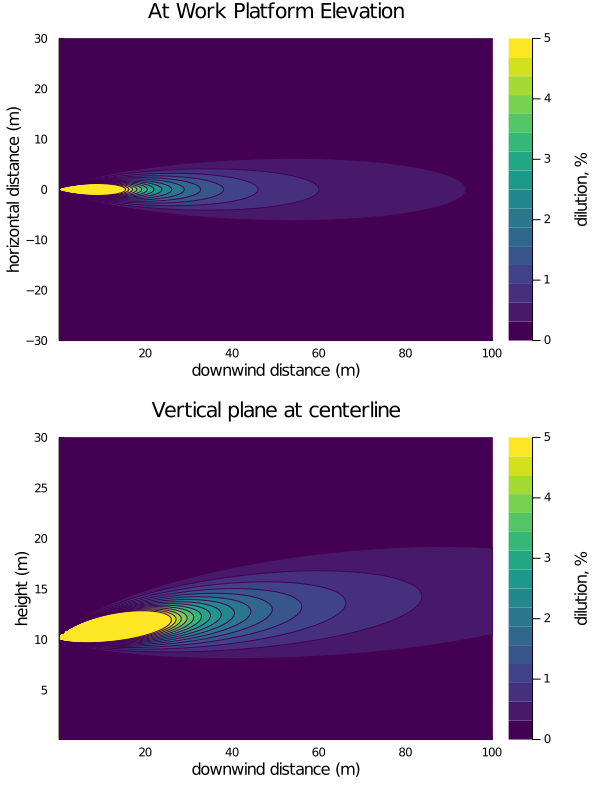

In [12]:
#| echo: false

Cₛ = Q/Vₛᵒ
Cₛ′ = ustrip(Cₛ)

l = @layout [a; b]

p1 = contour(xs, ys, (x,y) -> C(x, y, ustrip(h₁), u=u_worst, Q=Q_u, h=h_u, Δh=unstable_rise("D"), σy=σy("D"), σz=σz("D"))/Cₛ′*100,
        c= :viridis, fill = true, clim=(0, 5), colorbar_title="dilution, %",
        title="At Work Platform Elevation", ylabel= "horizontal distance (m)", xlabel="downwind distance (m)")
p2 = contour(xs, zs, (x,z) -> C(x, 0.0, z, u=u_worst, Q=Q_u, h=h_u, Δh=unstable_rise("D"), σy=σy("D"), σz=σz("D"))/Cₛ′*100,
        c= :viridis, fill = true, clim=(0, 5), colorbar_title="dilution, %",
        title="Vertical plane at centerline", ylabel= "height (m)", xlabel="downwind distance (m)")
plot(p1, p2, layout = l, size=(600,1.33*600))

## Thoughts on Code and Reusability

A simple way of taking the work from a previous notebook and adding to it is just to import the notebook. This loads the results into the current notebook including any function definitions and such.

For example

```julia

using NBInclude
@nbinclude("2020-12-05-gaussian_dispersion_example.ipynb")

```

I didn't do that here for two reasons:

1. I want these notebooks to be independent and stand on their own
1. I didn't write the previous notebook in a very extendable or reusable way

The second point is worth going into if one wants to build a library of worked out, generic, models as notebooks. This way an engineer can import previously defined models as needed for a particular analysis while also keeping the documentation for the models *in the model*. In the previous notebook I left most things in the global namespace and defined functions that used those global variables. Which is fine for that particular notebook but it means that the current workspace gets very cluttered when importing things and also those functions are not very re-usable as they were defined for a very particular example.

It's better, I think, to write functions that use keyword arguments for any important parameters that can then be passed as needed, instead of defining those parameters in the global namespace. Unless they are truly constants, like *g* the acceleration due to gravity or *R* the universal gas constant.

Another point is on the use of the library `Unitful`. It is convenient, and a good check, to have units propagate through calculations, however `Unitful` does not play nicely with all libraries. This is especially the case with `Plots` but it can also be real hassle to use with correlations that have lots of parameters. I think this is a good opportunity to take advantage of julia's multiple dispatch.

For example, suppose a correlation of the form $f \left( x \right) = a \cdot x^b$, this can be written in julia very simply (supposing *a* and *b* are parameters)

```julia

f(x; a, b) = a*x^b

```

But if we pass *x* with some units and don't pass the matching units with the parameter *a* this will throw an error. We could tediously work out the units for each set of parameters *a* and *b* to make the units cancel out properly, or we could use multiple dispatch to manage this for us

```julia

function f(x::Quantity; a, b)::Quantity
    x′ = ustrip(u"expected input unit", x)
    return f(x′, a=a, b=b)*1u"correlation output unit"
end

```

Where we convert the input to the expected units, whatever they may be, evaluate the function in a unitless way, then tack on the expected output units at the end. Now when we use *f(x)* in contexts without units, for example when plotting *f(x)*, it works as expected and if we pass a value of *x* with units attached we get the unit conversion/checking that we want from `Unitful`.